In [70]:
import math
import os
import gc
import time
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from google.colab import drive
drive.mount("/content/drive")

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow_datasets as tfds

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

root_folder='/content/drive/My Drive/Summarisationv2'
DATA_PATH = os.path.abspath(os.path.join(root_folder))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle

with open(DATA_PATH+"/in_tokenizer.pickle", 'rb') as handle:
    tokenizer_inputs = pickle.load(handle)

with open(DATA_PATH+"/out_tokenizer.pickle", 'rb') as handle:
    tokenizer_outputs = pickle.load(handle)

In [3]:
num_words_inputs = 16910
sos_token_input = [16908]
eos_token_input = [16909]
num_words_output = 17175
sos_token_output = [17173]
eos_token_output = [17174]

In [72]:
import sys
sys.path.append(root_folder)

In [74]:
import TransformerArchitecture
from TransformerArchitecture import *

In [75]:
def reloadmodel():
    # Clean the session
    tf.keras.backend.clear_session()
    # Create the Transformer model
    transformer = Transformer(vocab_size_enc=num_words_inputs,
                              vocab_size_dec=num_words_output,
                              d_model=512,
                              n_layers=4,
                              FFN_units=512,
                              n_heads=8,
                              dropout_rate=0.1)

    ckpt = tf.train.Checkpoint(transformer=transformer)

    ckpt_manager = tf.train.CheckpointManager(ckpt, DATA_PATH, max_to_keep=2)

    if ckpt_manager.latest_checkpoint:
        ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
        print("Last checkpoint restored.")
        
    return transformer

In [76]:
transformer = reloadmodel()

Last checkpoint restored.


In [77]:
class Summarising(tf.Module):
  def __init__(self, tokenizer_in, tokenizer_out, transformer):
    self.tokenizer_in = tokenizer_in
    self.tokenizer_out = tokenizer_out
    self.transformer = transformer

  def __call__(self, sentence, target_max_len=15):
    # Tokenize the input sequence using the tokenizer_in
    sentence = sos_token_input + self.tokenizer_in.encode(sentence) + eos_token_input
    enc_input = tf.expand_dims(sentence, axis=0)

    # Set the initial output sentence to sos
    out_sentence = sos_token_output
    output = tf.expand_dims(out_sentence, axis=0)

    # For max target len tokens
    for _ in range(target_max_len):
        predictions, _ = self.transformer(enc_input, output, False)
        prediction = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(prediction, axis=-1), tf.int32)
        if predicted_id == eos_token_output:
            return tf.squeeze(output, axis=0)
        output = tf.concat([output, predicted_id], axis=-1)

    output = tf.squeeze(output, axis=0)
    return output

In [78]:
summarising = Summarising(tokenizer_inputs, tokenizer_outputs, transformer)

In [79]:
sentence = "conservative firebrand tomi lahren filed lawsuit against glenn beck and theblaze friday alleging she was wrongfully terminated for recently expressing opinion the news she was fired which theblaze disputed"
summary_tok = summarising(sentence)

In [80]:
def extract(output):
    tokens = output.numpy()
    sentence = tokenizer_outputs.decode(
        [i for i in tokens if i < sos_token_output])    
    return sentence

In [81]:
extract(summary_tok)

'tomi lahren files lawsuit against glenn beck and theblaze alleging wrongful termination for expressing pro'

In [82]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)

In [83]:
def plot_attention_weights(sentence, summary_tok):
  input_sent = sos_token_input + tokenizer_inputs.encode(sentence) + eos_token_input
  enc_input = tf.expand_dims(input_sent, axis=0)
  _, attention_weights = transformer(enc_input, tf.expand_dims(summary_tok, axis=0), False)
  attention_heads = attention_weights['decoder_layer4_block2'][0]

  in_tokens = tokenizer_inputs.encode(sentence)
  in_tokens = tf.expand_dims(in_tokens, axis=0)

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, summary_tok, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

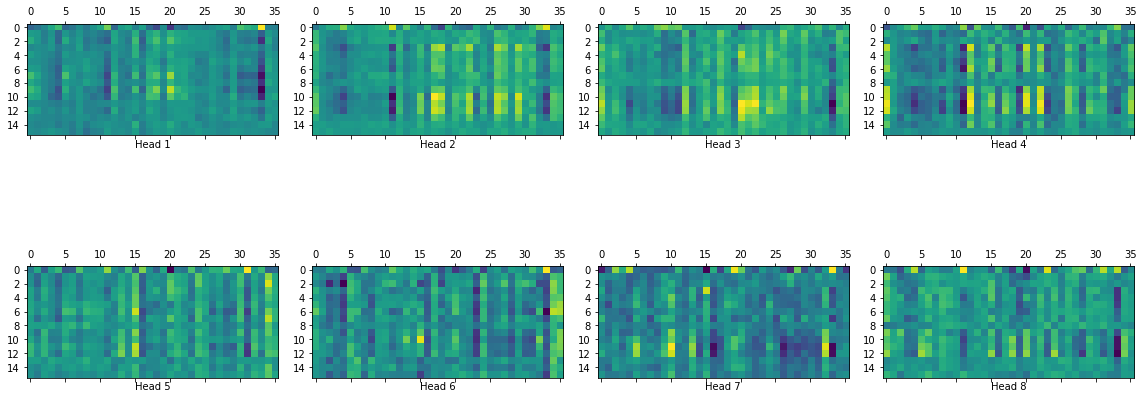

In [84]:
plot_attention_weights(sentence, summary_tok)

In [ ]:
!pip install streamlit

In [ ]:
import streamlit as st

# Describing the Web Application ###########################################################################
# Title of the application
st.title('Transformers and Semantics\n', )
st.subheader("by Michael")

# Sidebar options
option = st.sidebar.selectbox('Navigation',
                              ["Summarisation with Transformer",
                               "English to Mandarin Translation",
                               ])

st.set_option('deprecation.showfileUploaderEncoding', False)

In [ ]:
# Text Summarizer
elif option == "Summarisation with Transformer":
    st.header("Text Summarisation through Self-Attention")

    st.subheader("Enter a corpus that you want to summarize")
    text_input = st.text_area("Enter a paragraph", height=150)
    sentence_count = len(sent_tokenize(text_input))
    st.write("Number of sentences:", sentence_count)

    if st.button("Summarize"):
        out = summ(summarising(text_input))

        st.write("**Summary Output:**", out)